In [1]:
# Covid19 Analysis

# Analysis using public/private hospital
# http://plataforma.saude.gov.br/coronavirus/dados-abertos/      


In [2]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from datetime import datetime

/home/pedro/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# reading dataset

df = pd.read_csv('/home/pedro/Desktop/autoprognosis/code_v4/dataset/INFLUD-16-06-2020-Revisado.csv',sep=';',encoding = "ISO-8859-1")

# Inputing constraint in the dataset 

# Positive case:

df = df[df['PCR_SARS2']==1]
print(df.shape)


# Hospitalized people:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1]
print(df.shape)

# Hospitalized people with age small than 110:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]
print(df.shape)


/home/pedro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,59,61,62,63,103,105,119,126,128,129,130,132) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(97924, 134)
(90133, 134)
(66929, 134)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [4]:
# IDHM

# Reading IBGE code for each municipalities and separating it for IDHM index

df_atlas = pd.read_excel (r'/home/pedro/Desktop/autoprognosis/code_v4/dataset/AtlasBrasil_Consulta.xlsx')


# removind last interger in 'code' variable

df_atlas['code'] = df_atlas['code'].astype(str).str[:-1].astype(np.int64)


# Divinding IDHM in bins

IDHM_veryhigh  =  set(df_atlas['code'][df_atlas['IDHM2010']>=0.800])
print(len(IDHM_veryhigh))


IDHM_high  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.700)&(df_atlas['IDHM2010']<0.800))])
print(len(IDHM_high))


IDHM_medium  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.600)&(df_atlas['IDHM2010']<0.700))])
print(len(IDHM_medium))


IDHM_low  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.500)&(df_atlas['IDHM2010']<0.600))])
print(len(IDHM_low))


IDHM_verylow  =  set(df_atlas['code'][df_atlas['IDHM2010']<0.500])
print(len(IDHM_verylow))




df.loc[df['CO_MUN_NOT'].isin(IDHM_veryhigh) == True, 'IDHM'] = 5
df.loc[df['CO_MUN_NOT'].isin(IDHM_high) == True, 'IDHM'] = 4
df.loc[df['CO_MUN_NOT'].isin(IDHM_medium) == True, 'IDHM'] = 3
df.loc[df['CO_MUN_NOT'].isin(IDHM_low) == True, 'IDHM'] = 2
df.loc[df['CO_MUN_NOT'].isin(IDHM_verylow) == True, 'IDHM'] = 1


# Municipalities number analysed
#print(df['IDHM'].isnull().sum())


44
1890
2233
1367
32


In [5]:
# Private and public hospital separation

df_hospital = pd.read_csv('/home/pedro/Desktop/autoprognosis/code_v4/dataset/CNES_SUS.txt', sep='\t')


public   =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='S'])
private  =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='N'])


df.loc[df['CO_UNI_NOT'].isin(public) == True, 'HEALTH_SYSTEM'] = 1
df.loc[df['CO_UNI_NOT'].isin(private) == True, 'HEALTH_SYSTEM'] = 0


In [6]:
# Constraint on dataset: We only analyze people with  evolution, IDHM and Health system known

df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]
print(df.shape)


(63860, 136)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# To selecting features and target

df = df[['NU_IDADE_N','CS_SEXO','IDHM','CS_RACA','CS_ESCOL_N','SG_UF_NOT','CS_ZONA',\
'HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP','DISPNEIA','DIARREIA',\
'SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI','SIND_DOWN','DIABETES',\
'OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]


In [8]:
# adding comorbidities

df['SUM_COMORBIDITIES'] = df.iloc[:,17:-1].replace([9,2], 0).fillna(0).sum(axis=1)
df['SUM_SYMPTOMS'] = df.iloc[:,9:15].replace([9,2], 0).fillna(0).sum(axis=1)


In [9]:
# Ordering features

df = df[['NU_IDADE_N','CS_SEXO','IDHM','SUM_COMORBIDITIES','SUM_SYMPTOMS','CS_RACA','CS_ESCOL_N',\
'SG_UF_NOT','CS_ZONA','HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP',\
'DISPNEIA','DIARREIA','SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI',\
'SIND_DOWN','DIABETES','OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]

In [10]:
# Pre-Processing

df = df[df['EVOLUCAO'].notnull()][df['EVOLUCAO']!=9]#[df_BR['NU_IDADE_N'].notnull()]
df['CS_SEXO']=df['CS_SEXO'].replace({'M': 1, 'F':0, 'I':9, 'NaN':np.nan})


df.iloc[:,11:] = df.iloc[:,11:].replace(to_replace = 2.0, value =0) 

df['SG_UF_NOT'] = df['SG_UF_NOT'].map({'SP': 0, 'RJ':1, 'MG': 2 , 'ES':3, \
'RS':4, 'SC': 5, 'PR': 6, 'MT': 7, 'MS': 8, 'GO':9, 'DF':10, 'RO':11,'AC':12,'AM':13,\
'RR':14,'PA':15,'AP':16,'TO':17,'MA':18,'PI':19,'BA':20,'CE':21,'RN':22,'PB':23,'PE':24,'AL':25,'SE':26})


df.iloc[:,11:-1] = df.iloc[:,11:-1].fillna(0)


In [11]:
# feature
x = df.iloc[:,:-1]

# labels
y = df['EVOLUCAO']

In [12]:
# data separation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=5)

In [13]:
print(y_train.shape)
print(y_test.shape)

(51088,)
(12772,)


In [13]:
params = params = {'booster ':['gbtree'],
        'n_estimators': [200],          
        'eta':[0.2],    
        'max_depth':[4],
        'gamma': [1],
        'subsample': [0.9],
        'colsample_bytree': [0.9],
            }


                            
                            
xgb = XGBClassifier()
gs = GridSearchCV(estimator=xgb, param_grid=params, return_train_score=True, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train, y_train)


print(gs.best_score_)
print(gs.best_params_)


print(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['std_test_score'])

print(gs.cv_results_['mean_train_score'])   
print(gs.cv_results_['std_train_score'])   



clf = gs.best_estimator_
clf.fit(x_train, y_train)


# save the model to disk
filename_nn = 'xgb_with_symptoms.sav'
pickle.dump(clf, open(filename_nn, 'wb')) 

[15:47:42] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:47:47] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:47:51] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [13]:
# load the model from disk
loaded_model_xgb = pickle.load(open('xgb_with_symptoms.sav', 'rb'))


In [14]:
# To predicting 
xgb_pred = loaded_model_xgb.predict_proba(x_test)

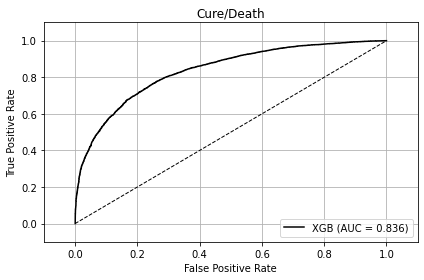

In [15]:
# Plot Roc Curve

colors = ['blue']
linestyles = ['--']
#plt.figure(figsize=(5,5))
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred[:,1],pos_label=1)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr,
             color='k',
             linestyle='-',
             label='%s (AUC = %0.3f)' % ('XGB', roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='black',
         linewidth=1)

plt.title('')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.title('Cure/Death')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
#plt.savefig('roc_xgb_public_private_without_symptoms.pdf')
plt.show()  

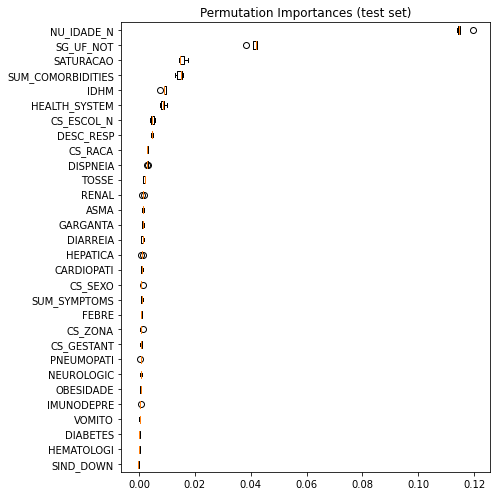

In [16]:
from sklearn.inspection import permutation_importance


result = permutation_importance(loaded_model_xgb, x_test, y_test, n_repeats=5,
                                random_state=42, n_jobs=2, scoring='average_precision')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
#ax.set_xscale('log')
fig.tight_layout()
#plt.savefig('importance_permutation_train.pdf')
plt.savefig('importance_permutation_train.png')
plt.show()  

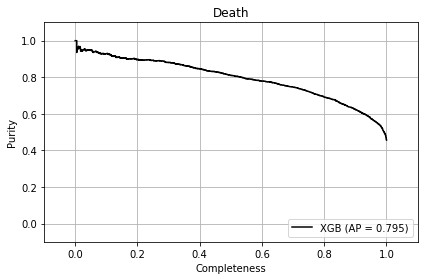

In [18]:
# Plot Purity x Completeness 


precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred[:,0],pos_label=0)
average_precision = average_precision_score(1-y_test, xgb_pred[:,0])
plt.plot(recall, precision, color='k',linestyle='-',label='%s (AP = %0.3f)' % ('XGB', average_precision))

plt.legend(loc='lower right')


plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness')
plt.ylabel('Purity')
plt.title('Death')
plt.tight_layout()
plt.show()  

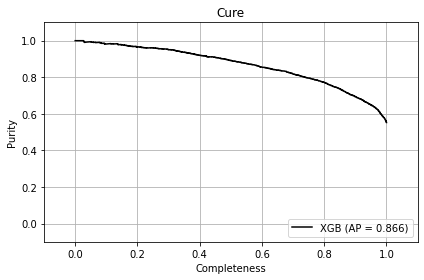

In [19]:
# Plot Purity x Completeness 


precision, recall, thresholds = precision_recall_curve(y_test, xgb_pred[:,1],pos_label=1)
average_precision = average_precision_score(y_test, xgb_pred[:,1])
plt.plot(recall, precision, color='k',linestyle='-',label='%s (AP = %0.3f)' % ('XGB', average_precision))

plt.legend(loc='lower right')


plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness')
plt.ylabel('Purity')
plt.title('Cure')
plt.tight_layout()
plt.show()  

In [20]:
wordList = ['FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP','DISPNEIA','DIARREIA','SATURACAO',\
'CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI','SIND_DOWN','DIABETES','OBESIDADE',\
'NEUROLOGIC','IMUNODEPRE']



for word in wordList:
    pred = loaded_model_xgb.predict_proba(x_test[x_test[word]==1])
       
    fpr, tpr, thresholds = roc_curve(y_test[x_test[word]==1], pred[:,1], pos_label=1)
    pred_auc = auc(x=fpr, y=tpr)
    
    
    print('%s (AUC = %0.3f), number of data %d' % (word, pred_auc, y_test[x_test[word]==1].shape[0]) )

FEBRE (AUC = 0.835), number of data 9399
VOMITO (AUC = 0.822), number of data 999
TOSSE (AUC = 0.830), number of data 9850
GARGANTA (AUC = 0.845), number of data 2586
DESC_RESP (AUC = 0.827), number of data 7639
DISPNEIA (AUC = 0.829), number of data 9280
DIARREIA (AUC = 0.827), number of data 1729
SATURACAO (AUC = 0.807), number of data 7562
CARDIOPATI (AUC = 0.789), number of data 4356
HEPATICA (AUC = 0.674), number of data 109
ASMA (AUC = 0.830), number of data 378
PNEUMOPATI (AUC = 0.735), number of data 516
RENAL (AUC = 0.724), number of data 598
HEMATOLOGI (AUC = 0.740), number of data 126
SIND_DOWN (AUC = 0.756), number of data 36
DIABETES (AUC = 0.773), number of data 3311
OBESIDADE (AUC = 0.749), number of data 475
NEUROLOGIC (AUC = 0.714), number of data 514
IMUNODEPRE (AUC = 0.753), number of data 406


In [21]:
# little check

print(len(y_test[x_test['FEBRE']==1]))
print(len(y_test[x_test['FEBRE']==0]))

print(len(y_test[x_test['FEBRE']==1]))
print(len(y_test[x_test['FEBRE']==0]))

9399
3160
9399
3160


In [22]:
# Gender

# Male
pred_male = loaded_model_xgb.predict_proba(x_test[x_test['CS_SEXO']==1])
fpr_male, tpr_male, thresholds_male = roc_curve(y_test[x_test['CS_SEXO']==1], pred_male[:,1], pos_label=1)
pred_auc_male = auc(x=fpr_male, y=tpr_male)


# Female
pred_female = loaded_model_xgb.predict_proba(x_test[x_test['CS_SEXO']==0])
fpr_female, tpr_female, thresholds_female = roc_curve(y_test[x_test['CS_SEXO']==0], pred_female[:,1], pos_label=1)
pred_auc_female = auc(x=fpr_female, y=tpr_female)
    
    
print('Male AUC = %0.3f, number of data %d' % (pred_auc_male, y_test[x_test['CS_SEXO']==1].shape[0]) )
print('Female AUC = %0.3f, number of data %d' % (pred_auc_female, y_test[x_test['CS_SEXO']==0].shape[0]) )

Male AUC = 0.836, number of data 7266
Female AUC = 0.837, number of data 5506


In [23]:
# Gender

# public
pred_public = loaded_model_xgb.predict_proba(x_test[x_test['HEALTH_SYSTEM']==1])
fpr_public, tpr_public, thresholds_public = roc_curve(y_test[x_test['HEALTH_SYSTEM']==1], pred_public[:,1], pos_label=1)
pred_auc_public = auc(x=fpr_public, y=tpr_public)


# private
pred_private = loaded_model_xgb.predict_proba(x_test[x_test['HEALTH_SYSTEM']==0])
fpr_private, tpr_private, thresholds_private = roc_curve(y_test[x_test['HEALTH_SYSTEM']==0], pred_private[:,1], pos_label=1)
pred_auc_private = auc(x=fpr_private, y=tpr_private)
    
    
print('Public AUC = %0.3f, number of data %d' % (pred_auc_public, y_test[x_test['HEALTH_SYSTEM']==1].shape[0]) )
print('Private AUC = %0.3f, number of data %d' % (pred_auc_private, y_test[x_test['HEALTH_SYSTEM']==0].shape[0]) )

Public AUC = 0.824, number of data 9594
Private AUC = 0.850, number of data 3178


In [24]:
# Pregancy

# pregnant
pred_pregnant = loaded_model_xgb.predict_proba(x_test[(x_test['CS_GESTANT']==1)|(x_test['CS_GESTANT']==2)|(x_test['CS_GESTANT']==3)|(x_test['CS_GESTANT']==4)])
fpr_pregnant, tpr_pregnant, thresholds_pregnant = roc_curve(y_test[(x_test['CS_GESTANT']==1)|(x_test['CS_GESTANT']==2)|(x_test['CS_GESTANT']==3)|(x_test['CS_GESTANT']==4)], pred_pregnant[:,1], pos_label=1)
pred_auc_pregnant = auc(x=fpr_pregnant, y=tpr_pregnant)


# non-pregnant
pred_non_preg = loaded_model_xgb.predict_proba(x_test[x_test['CS_GESTANT']==5])
fpr_non_preg, tpr_non_preg, thresholds_non_preg = roc_curve(y_test[x_test['CS_GESTANT']==5], pred_non_preg[:,1], pos_label=1)
pred_auc_non_preg = auc(x=fpr_non_preg, y=tpr_non_preg)
    
    
print('Pregnant AUC = %0.3f, number of data %d' % (pred_auc_pregnant, y_test[(x_test['CS_GESTANT']==1)|(x_test['CS_GESTANT']==2)|(x_test['CS_GESTANT']==3)|(x_test['CS_GESTANT']==4)].shape[0]) )
print('Non-pregnant AUC = %0.3f, number of data %d' % (pred_auc_non_preg, y_test[x_test['CS_GESTANT']==5].shape[0]) )

Pregnant AUC = 0.879, number of data 103
Non-pregnant AUC = 0.832, number of data 3874


In [25]:
# Color

# branco
pred_branco = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==1])
fpr_branco, tpr_branco, thresholds_branco = roc_curve(y_test[x_test['CS_RACA']==1], pred_branco[:,1], pos_label=1)
pred_auc_branco = auc(x=fpr_branco, y=tpr_branco)


# preto
pred_preto = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==2])
fpr_preto, tpr_preto, thresholds_preto = roc_curve(y_test[x_test['CS_RACA']==2], pred_preto[:,1], pos_label=1)
pred_auc_preto = auc(x=fpr_preto, y=tpr_preto)



# amarelo
pred_amarelo = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==3])
fpr_amarelo, tpr_amarelo, thresholds_amarelo = roc_curve(y_test[x_test['CS_RACA']==3], pred_amarelo[:,1], pos_label=1)
pred_auc_amarelo = auc(x=fpr_amarelo, y=tpr_amarelo)
  
    
    
# pardo
pred_pardo = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==4])
fpr_pardo, tpr_pardo, thresholds_pardo = roc_curve(y_test[x_test['CS_RACA']==4], pred_pardo[:,1], pos_label=1)
pred_auc_pardo = auc(x=fpr_pardo, y=tpr_pardo)
  
    
    
# indigena
pred_indigena = loaded_model_xgb.predict_proba(x_test[x_test['CS_RACA']==5])
fpr_indigena, tpr_indigena, thresholds_indigena = roc_curve(y_test[x_test['CS_RACA']==5], pred_indigena[:,1], pos_label=1)
pred_auc_indigena = auc(x=fpr_indigena, y=tpr_indigena)
      
    
    
print('Branco AUC = %0.3f, number of data %d' % (pred_auc_branco, y_test[x_test['CS_RACA']==1].shape[0]) )
print('Preto AUC = %0.3f, number of data %d' % (pred_auc_preto, y_test[x_test['CS_RACA']==2].shape[0]) )
print('Amarelo AUC = %0.3f, number of data %d' % (pred_auc_amarelo, y_test[x_test['CS_RACA']==3].shape[0]) )
print('Pardo AUC = %0.3f, number of data %d' % (pred_auc_pardo, y_test[x_test['CS_RACA']==4].shape[0]) )
print('Indigena AUC = %0.3f, number of data %d' % (pred_auc_indigena, y_test[x_test['CS_RACA']==5].shape[0]) )


Branco AUC = 0.831, number of data 3937
Preto AUC = 0.807, number of data 549
Amarelo AUC = 0.774, number of data 117
Pardo AUC = 0.829, number of data 3638
Indigena AUC = 0.689, number of data 21


In [26]:
# Education

# Illiterate
pred_illiterate = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==0])
fpr_illiterate, tpr_illiterate, thresholds_illiterate = roc_curve(y_test[x_test['CS_ESCOL_N']==0], pred_illiterate[:,1], pos_label=1)
pred_auc_illiterate = auc(x=fpr_illiterate, y=tpr_illiterate)


# Fundamental I
pred_fundI = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==1])
fpr_fundI, tpr_fundI, thresholds_fundI = roc_curve(y_test[x_test['CS_ESCOL_N']==1], pred_fundI[:,1], pos_label=1)
pred_auc_fundI = auc(x=fpr_fundI, y=tpr_fundI)



# Fundamental II
pred_fundII = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==2])
fpr_fundII, tpr_fundII, thresholds_fundII = roc_curve(y_test[x_test['CS_ESCOL_N']==2], pred_fundII[:,1], pos_label=1)
pred_auc_fundII = auc(x=fpr_fundII, y=tpr_fundII)
  
    
    
# Medium
pred_medium = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==3])
fpr_medium, tpr_medium, thresholds_medium = roc_curve(y_test[x_test['CS_ESCOL_N']==3], pred_medium[:,1], pos_label=1)
pred_auc_medium = auc(x=fpr_medium, y=tpr_medium)
  
    
    
# University
pred_university = loaded_model_xgb.predict_proba(x_test[x_test['CS_ESCOL_N']==4])
fpr_university, tpr_university, thresholds_university = roc_curve(y_test[x_test['CS_ESCOL_N']==4], pred_university[:,1], pos_label=1)
pred_auc_university = auc(x=fpr_university, y=tpr_university)
      
    
    
print('Illiterate AUC = %0.3f, number of data %d' % (pred_auc_illiterate, y_test[x_test['CS_ESCOL_N']==0].shape[0]) )
print('Fundamental I AUC = %0.3f, number of data %d' % (pred_auc_fundI, y_test[x_test['CS_ESCOL_N']==1].shape[0]) )
print('Fundamental II AUC = %0.3f, number of data %d' % (pred_auc_fundII, y_test[x_test['CS_ESCOL_N']==2].shape[0]) )
print('Medium AUC = %0.3f, number of data %d' % (pred_auc_medium, y_test[x_test['CS_ESCOL_N']==3].shape[0]) )
print('University AUC = %0.3f, number of data %d' % (pred_auc_university, y_test[x_test['CS_ESCOL_N']==4].shape[0]) )


Illiterate AUC = 0.781, number of data 260
Fundamental I AUC = 0.782, number of data 920
Fundamental II AUC = 0.798, number of data 735
Medium AUC = 0.851, number of data 1401
University AUC = 0.848, number of data 705


In [27]:
# Area

# Urban
pred_urban = loaded_model_xgb.predict_proba(x_test[x_test['CS_ZONA']==1])
fpr_urban, tpr_urban, thresholds_urban = roc_curve(y_test[x_test['CS_ZONA']==1], pred_urban[:,1], pos_label=1)
pred_auc_urban = auc(x=fpr_urban, y=tpr_urban)


# Rural
pred_rural = loaded_model_xgb.predict_proba(x_test[x_test['CS_ZONA']==2])
fpr_rural, tpr_rural, thresholds_rural = roc_curve(y_test[x_test['CS_ZONA']==2], pred_rural[:,1], pos_label=1)
pred_auc_rural = auc(x=fpr_rural, y=tpr_rural)



# Peri-urban
pred_periurban = loaded_model_xgb.predict_proba(x_test[x_test['CS_ZONA']==3])
fpr_periurban, tpr_periurban, thresholds_periurban = roc_curve(y_test[x_test['CS_ZONA']==3], pred_periurban[:,1], pos_label=1)
pred_auc_periurban = auc(x=fpr_periurban, y=tpr_periurban)
  
         
    
    
print('Urban AUC = %0.3f, number of data %d' % (pred_auc_urban, y_test[x_test['CS_ZONA']==1].shape[0]) )
print('Rural AUC = %0.3f, number of data %d' % (pred_auc_rural, y_test[x_test['CS_ZONA']==2].shape[0]) )
print('Periurban AUC = %0.3f, number of data %d' % (pred_auc_periurban, y_test[x_test['CS_ZONA']==3].shape[0]) )


Urban AUC = 0.835, number of data 10891
Rural AUC = 0.814, number of data 309
Periurban AUC = 0.916, number of data 52


In [28]:
# IDHM


# Very High
pred_veryhight = loaded_model_xgb.predict_proba(x_test[x_test['IDHM']==5])
fpr_veryhight, tpr_veryhight, thresholds_veryhight = roc_curve(y_test[x_test['IDHM']==5], pred_veryhight[:,1], pos_label=1)
pred_auc_veryhight = auc(x=fpr_veryhight, y=tpr_veryhight)


# High
pred_hight = loaded_model_xgb.predict_proba(x_test[x_test['IDHM']==4])
fpr_hight, tpr_hight, thresholds_hight = roc_curve(y_test[x_test['IDHM']==4], pred_hight[:,1], pos_label=1)
pred_auc_hight = auc(x=fpr_hight, y=tpr_hight)



# Medium Low
pred_mediumLow = loaded_model_xgb.predict_proba(x_test[((x_test['IDHM']==3)\
|(x_test['IDHM']==2)|(x_test['IDHM']==1))])

fpr_mediumLow, tpr_mediumLow, thresholds_mediumLow = roc_curve(y_test[((x_test['IDHM']==3)\
|(x_test['IDHM']==2)|(x_test['IDHM']==1))], pred_mediumLow[:,1], pos_label=1)
pred_auc_mediumLow = auc(x=fpr_mediumLow, y=tpr_mediumLow)
  
         
    
    
print('Very High AUC = %0.3f, number of data %d' % (pred_auc_veryhight, y_test[x_test['IDHM']==5].shape[0]) )
print('Highl AUC = %0.3f, number of data %d' % (pred_auc_hight, y_test[x_test['IDHM']==4].shape[0]) )
print('Medium Low AUC = %0.3f, number of data %d' % (pred_auc_mediumLow, y_test[((x_test['IDHM']==3)\
|(x_test['IDHM']==2)|(x_test['IDHM']==1))].shape[0]) )


Very High AUC = 0.815, number of data 5252
Highl AUC = 0.831, number of data 6694
Medium Low AUC = 0.818, number of data 826


In [29]:
# Macroregions


# Macro Regions

northeast  =  set([18,19,20,21,22,23,24,25,26])
north  =  set([11,12,13,14,15,16,17])
midwest  =  set([7,8,9,10])
southeast  =  set([0,1,2,3])
south = set([4,5,6])


#df_BR['SG_UF_NOT'] = df_BR['SG_UF_NOT'].map({'SP': 0, 'RJ':1, 'MG': 2 , 'ES':3, \
#'RS':4, 'SC': 5, 'PR': 6, 'MT': 7, 'MS': 8, 'GO':9, 'DF':10, 'RO':11,'AC':12,'AM':13,\
#'RR':14,'PA':15,'AP':16,'TO':17,'MA':18,'PI':19,'BA':20,'CE':21,'RN':22,'PB':23,'PE':24,'AL':25,'SE':26})


# North
pred_north = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(north)])
fpr_north, tpr_north, thresholds_north = roc_curve(y_test[x_test['SG_UF_NOT'].isin(north)], pred_north[:,1],\
pos_label=1)
pred_auc_north = auc(x=fpr_north, y=tpr_north)



# Northeast
pred_northeast = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(northeast)])
fpr_northeast, tpr_northeast, thresholds_northeast = roc_curve(y_test[x_test['SG_UF_NOT'].isin(northeast)], pred_northeast[:,1], pos_label=1)
pred_auc_northeast = auc(x=fpr_northeast, y=tpr_northeast)



# Midwest
pred_midwest = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(midwest)])
fpr_midwest, tpr_midwest, thresholds_midwest = roc_curve(y_test[x_test['SG_UF_NOT'].isin(midwest)], pred_midwest[:,1], pos_label=1)
pred_auc_midwest = auc(x=fpr_midwest, y=tpr_midwest)
  
    
    
# Southeast
pred_southeast = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(southeast)])
fpr_southeast, tpr_southeast, thresholds_southeast = roc_curve(y_test[x_test['SG_UF_NOT'].isin(southeast)], pred_southeast[:,1], pos_label=1)
pred_auc_southeast = auc(x=fpr_southeast, y=tpr_southeast)
  
    
    
# South
pred_south = loaded_model_xgb.predict_proba(x_test[x_test['SG_UF_NOT'].isin(south)])
fpr_south, tpr_south, thresholds_south = roc_curve(y_test[x_test['SG_UF_NOT'].isin(south)], pred_south[:,1], pos_label=1)
pred_auc_south = auc(x=fpr_south, y=tpr_south)
      
    
    
print('North AUC = %0.3f, number of data %d' % (pred_auc_north, y_test[x_test['SG_UF_NOT'].isin(north)].shape[0]) )
print('Northeast AUC = %0.3f, number of data %d' % (pred_auc_northeast, y_test[x_test['SG_UF_NOT'].isin(northeast)].shape[0]) )
print('Midwest AUC = %0.3f, number of data %d' % (pred_auc_midwest, y_test[x_test['SG_UF_NOT'].isin(midwest)].shape[0]) )
print('Southeast AUC = %0.3f, number of data %d' % (pred_auc_medium, y_test[x_test['SG_UF_NOT'].isin(southeast)].shape[0]) )
print('South AUC = %0.3f, number of data %d' % (pred_auc_south, y_test[x_test['SG_UF_NOT'].isin(south)].shape[0]) )

North AUC = 0.813, number of data 1312
Northeast AUC = 0.803, number of data 2187
Midwest AUC = 0.880, number of data 337
Southeast AUC = 0.851, number of data 8286
South AUC = 0.822, number of data 650
